In [ ]:
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Model
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/tcc/dataset'

MessageError: Error: credential propagation was unsuccessful

In [ ]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/tcc/dataset_2'
MODEL_PATH = '/content/drive/MyDrive/tcc/model.keras'

Mounted at /content/drive


In [ ]:
img_height, img_width = 32, 32
batch_size = 64
epochs = 100

In [ ]:
def extract_label(filename):
    match = re.search(r'r(\d+)_s([\d\.]+)', filename)
    if match:
        ratio = int(match.group(1))
        scale = float(match.group(2))
        return ratio, scale
    return None, None

In [ ]:
image_paths, ratio_labels, scale_labels = [], [], []
for fname in os.listdir(dataset_path):
    full_path = os.path.join(dataset_path, fname)
    if os.path.isfile(full_path):
        ratio, scale = extract_label(fname)
        if ratio is not None and scale is not None:
            image_paths.append(full_path)
            ratio_labels.append(ratio)
            scale_labels.append(scale)

In [ ]:
unique_scales = sorted(set(scale_labels))
unique_ratios = sorted(set(ratio_labels))
ratio_to_index = {v: i for i, v in enumerate(unique_ratios)}
scale_to_index = {v: i for i, v in enumerate(unique_scales)}
encoded_ratios = [ratio_to_index[r] for r in ratio_labels]
encoded_scales = [scale_to_index[s] for s in scale_labels]

train_paths, test_paths, train_ratios, test_ratios, train_scales, test_scales = train_test_split(
    image_paths, encoded_ratios, encoded_scales, test_size=0.1, random_state=42
)
train_paths, val_paths, train_ratios, val_ratios, train_scales, val_scales = train_test_split(
    train_paths, train_ratios, train_scales, test_size=0.1, random_state=42
)

In [ ]:

def load_image(path, ratio, scale):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([img_height, img_width, 1])
    return img.numpy(), {"ratio_output": ratio, "scale_output": scale}

In [ ]:
def make_dataset(paths, ratios, scales):
    images = []
    y_ratios = []
    y_scales = []

    for path, ratio, scale in zip(paths, ratios, scales):
        img, labels = load_image(path, ratio, scale)
        images.append(img)
        y_ratios.append(labels["ratio_output"])
        y_scales.append(labels["scale_output"])

    images = np.array(images, dtype=np.float32)
    y_ratios = np.array(y_ratios, dtype=np.int32)
    y_scales = np.array(y_scales, dtype=np.int32)
    return images, y_ratios, y_scales

In [ ]:
train_images, train_y_ratios, train_y_scales = make_dataset(train_paths, train_ratios, train_scales)
val_images, val_y_ratios, val_y_scales = make_dataset(val_paths, val_ratios, val_scales)
test_images, test_y_ratios, test_y_scales = make_dataset(test_paths, test_ratios, test_scales)

In [ ]:
def build_ratio_scale_cnn(input_shape, num_ratio_classes, num_scale_classes):
    inputs = Input(shape=input_shape, name='multi_input')

    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)

    shared = Dense(128, activation='relu')(x)

    # saida para ratio
    ratio_branch = Dense(128, activation='relu')(shared)
    ratio_branch = Dropout(0.5)(ratio_branch)
    ratio_output = Dense(num_ratio_classes, activation='softmax', name='ratio_output')(ratio_branch)

    # saida para scale
    scale_branch = Dense(128, activation='relu')(shared)
    scale_branch = Dropout(0.5)(scale_branch)
    scale_output = Dense(num_scale_classes, activation='softmax', name='scale_output')(scale_branch)

    model = Model(inputs=inputs, outputs=[ratio_output, scale_output])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(
        optimizer=optimizer,
        loss={
            'ratio_output': 'sparse_categorical_crossentropy',
            'scale_output': 'sparse_categorical_crossentropy',
        },
        loss_weights={
            'ratio_output': 6,
            'scale_output': 1,
        },
        metrics={
            'ratio_output': 'accuracy',
            'scale_output': 'accuracy',
        }
    )
    return model

multi_model = build_ratio_scale_cnn((img_height, img_width, 1), len(unique_ratios), len(unique_scales))

In [ ]:
multi_model = keras.models.load_model(MODEL_PATH)

In [ ]:
print("multi model: ")
multi_model.summary()

multi model: 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ multi_input         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │        320 │ multi_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 13, 13,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 6, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2304)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    295,040 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ratio_output        │ (None, 7)         │        903 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_output        │ (None, 3)         │        387 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 348,170 (1.33 MB)

 Trainable params: 348,170 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

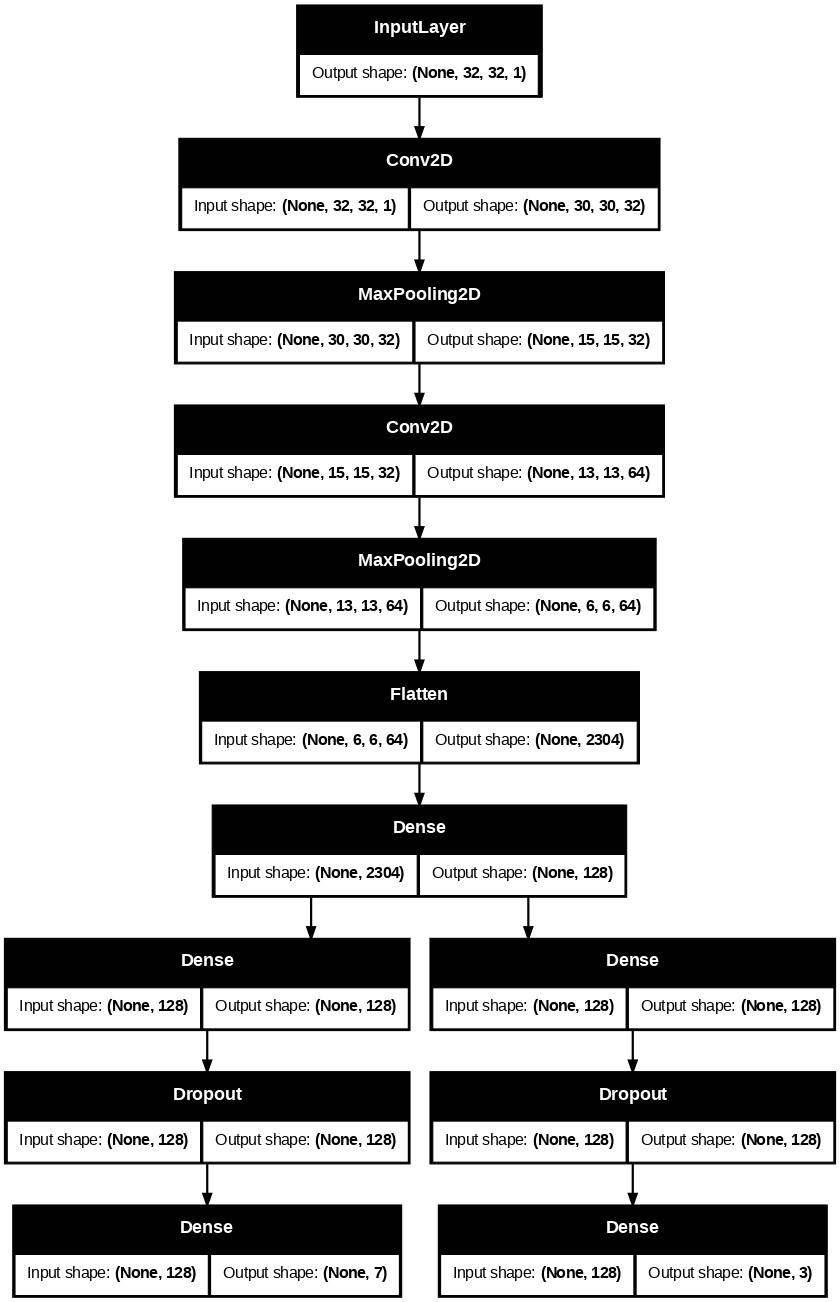

In [ ]:
keras.utils.plot_model(multi_model, 'fashion_mnist_model.png', dpi=80, show_shapes=True)

In [ ]:
print('treino', len(train_paths))
print('validação', len(val_paths))
print('teste', len(test_paths))

treino 2041
validação 227
teste 252


In [ ]:
#treinamento
history_multi = multi_model.fit(
    x=train_images,
    y={
        "ratio_output": train_y_ratios,
        "scale_output": train_y_scales,
    },
    validation_data=(
        val_images,
        {
            "ratio_output": val_y_ratios,
            "scale_output": val_y_scales,
        }
    ),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - loss: 12.7426 - ratio_output_accuracy: 0.1444 - ratio_output_loss: 1.9427 - scale_output_accuracy: 0.3791 - scale_output_loss: 1.0862 - val_loss: 11.9416 - val_ratio_output_accuracy: 0.2423 - val_ratio_output_loss: 1.8221 - val_scale_output_accuracy: 0.5727 - val_scale_output_loss: 1.0091
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 11.4231 - ratio_output_accuracy: 0.2846 - ratio_output_loss: 1.7392 - scale_output_accuracy: 0.5195 - scale_output_loss: 0.9874 - val_loss: 9.0302 - val_ratio_output_accuracy: 0.3612 - val_ratio_output_loss: 1.3384 - val_scale_output_accuracy: 0.4978 - val_scale_output_loss: 0.9726
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 9.1063 - ratio_output_accuracy: 0.3976 - ratio_output_loss: 1.3603 - scale_output_accuracy: 0.5185 - scale_output_loss: 0.9442 - val_loss: 6.5512 - val_ratio_output_accuracy: 0.6123 - val_ratio_output_loss: 0.9782 - val_scale_output_accuracy: 0.7048 - 

In [ ]:
multi_model.save("/content/drive/MyDrive/tcc/model.keras")

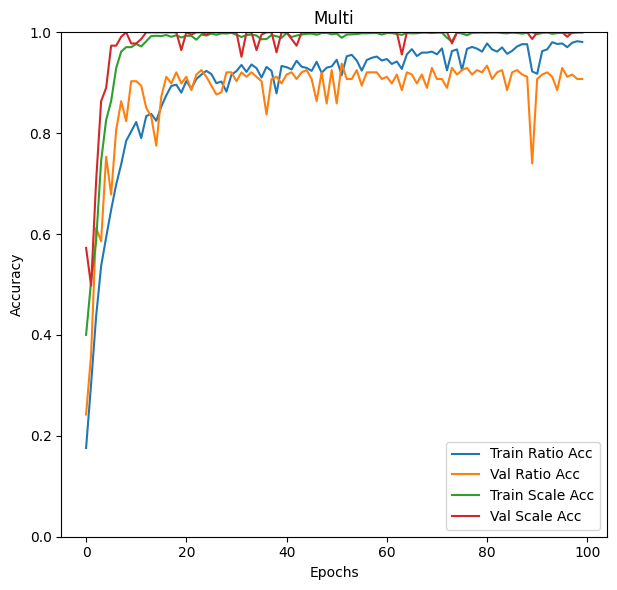

In [ ]:
plt.figure(figsize=(18, 6))
# Plot do modelo multi_model (duas saídas)
plt.subplot(1, 3, 3)
plt.plot(history_multi.history['ratio_output_accuracy'], label='Train Ratio Acc')
plt.plot(history_multi.history['val_ratio_output_accuracy'], label='Val Ratio Acc')
plt.plot(history_multi.history['scale_output_accuracy'], label='Train Scale Acc')
plt.plot(history_multi.history['val_scale_output_accuracy'], label='Val Scale Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Multi")
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
#avaliação ratio e scale
results = multi_model.evaluate(
    x=test_images,
    y={
        "ratio_output": test_y_ratios,
        "scale_output": test_y_scales,
    },
    return_dict=True,
)

for k, v in results.items():
    print(f"{k}: {v:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6408 - ratio_output_accuracy: 0.9371 - ratio_output_loss: 0.2732 - scale_output_accuracy: 1.0000 - scale_output_loss: 3.8387e-04
loss: 2.1405
ratio_output_accuracy: 0.9206
ratio_output_loss: 0.3556
scale_output_accuracy: 1.0000
scale_output_loss: 0.0002


In [ ]:
# predictions
pred_y_ratios, pred_y_scales = multi_model.predict(test_images)
pred_y_ratios = np.argmax(pred_y_ratios, axis=1)
pred_y_scales = np.argmax(pred_y_scales, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


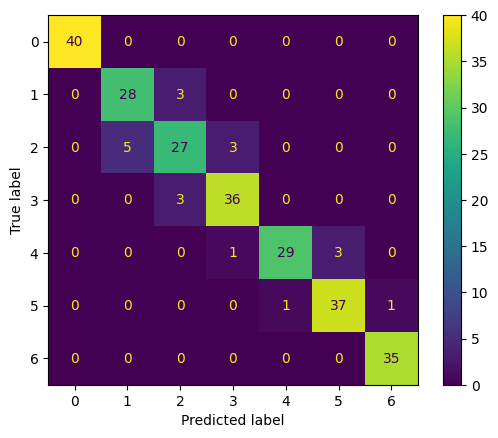

In [ ]:
# confusion matrix for ratio
cm = confusion_matrix(test_y_ratios, pred_y_ratios)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
disp.plot(cmap='viridis');

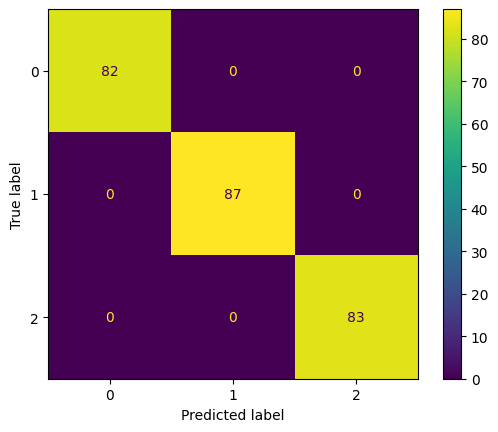

In [ ]:
# confusion matrix for scale
cm = confusion_matrix(test_y_scales, pred_y_scales)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [ ]:
def to_labels(y):
    y = np.asarray(y)
    if y.ndim > 1 and y.shape[-1] > 1:
        y = np.argmax(y, axis=-1)
    return y.astype(int).ravel()

y_true = to_labels(test_y_ratios)
y_pred = to_labels(pred_y_ratios)

f1_ratios = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("F1 (ratios):", f1_ratios)

print("\nReport:\n", classification_report(y_true, y_pred, zero_division=0))

F1 (ratios): 0.9176813323534679

Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.85      0.90      0.88        31
           2       0.82      0.77      0.79        35
           3       0.90      0.92      0.91        39
           4       0.97      0.88      0.92        33
           5       0.93      0.95      0.94        39
           6       0.97      1.00      0.99        35

    accuracy                           0.92       252
   macro avg       0.92      0.92      0.92       252
weighted avg       0.92      0.92      0.92       252



In [ ]:
def to_labels(y):
    y = np.asarray(y)
    if y.ndim > 1 and y.shape[-1] > 1:
        y = np.argmax(y, axis=-1)
    return y.astype(int).ravel()

y_true = to_labels(test_y_scales)
y_pred = to_labels(pred_y_scales)

f1_scales = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("F1 (scales):", f1_scales)

print("\nReport:\n", classification_report(y_true, y_pred, zero_division=0))

F1 (scales): 0.9921470805617147

Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       0.98      1.00      0.99        87
           2       1.00      0.98      0.99        83

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252

